## 5.1 生成式文本模型的评估

![Alt text](imgs/PixPin_2025-07-15_18-26-40.png)

这两段文本的token ID 如下：
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.039

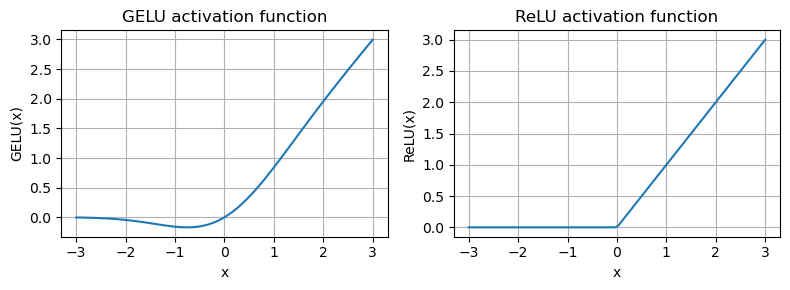

torch.Size([2, 3, 768])
layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606
layers.0.0.weight has gradient mean of 0.2216978669166565
layers.1.0.weight has gradient mean of 0.20694100856781006
layers.2.0.weight has gradient mean of 0.3289698660373688
layers.3.0.weight has gradient mean of 0.2665731906890869
layers.4.0.weight has gradient mean of 1.3258538246154785

===== Self-Attention 结果 (含位置编码) =====

       x1        x2       x3       T1       T2       T3       T4       T5       T6       o1       o2       o3
 1.271471  0.690302 0.890005 0.315381 0.239435 0.105702 0.044346 0.066093 0.229044 1.273928 1.060221 0.435727
 1.459297  0.453853 0.660009 0.296198 0.233471 0.115046 0.054239 0.076627 0.224420 1.236005 1.028942 0.420495
 0.711120 -

In [1]:
%run ./4_model_for_gpt.ipynb

In [2]:
import torch
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,        #A
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,             #B
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_porj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

我们通过前一章节中介绍的 generate_text_simple 函数来使用 GPTmodel 实例，同时引入了两个实用函数：text_to_token_ids 和token_ids_to_text。这些函数简化了文本与 token 表示之间的转换，本章中我们将多次使用这种技术。图 5.3 可以帮助我们更清楚地理解这一过程。

![Alt text](imgs/PixPin_2025-07-15_18-38-56.png)

图 5.3 展示了使用 GPT 模型生成文本的三个主要步骤。首先，分词器将输入文本转换为一系列 token ID（在第 2 章中已有讨论）。然后，模型接收这些 token ID 并生成对应的 logits（即词汇表中每个 token 的概率分布，具体见第 4 章）。最后，将 logits 转换回 token ID，分词器将其解码为可读的文本，完成从文本输入到文本输出的循环。

In [3]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### 5.1.2 文本生成损失的计算

![Alt text](imgs/PixPin_2025-07-15_18-59-38.png)


In [4]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]])    # "I really like"]
# Matching these inputs, the `targets` contain the token IDs we aim for the model to produce:
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [107, 588, 11311]]) # " really like chocolate"]

In [5]:
with torch.no_grad():                  #A
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape)

#A 禁用梯度跟踪，因为我们尚未进行训练

torch.Size([2, 3, 50257])


第一个数字 2 表示输入中的两个样本（行），即批次大小。第二个数字 3 表示每个样本包含的 token 数量。最后一个数字表示嵌入维度的大小，通常由词汇表大小决定，前面章节已讨论。

通过 softmax 函数将 logits 转换为概率后，第 4 章的 generate_text_simple 函数会将概率得分进一步转换回文本，这一过程在图 5.4 的步骤 3 到步骤 5 中进行了展示。

In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [7]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")
#When we decode these tokens, we find that these output tokens are quite different from the target tokens we want the model to generate:

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


文本评估过程的一部分（如图 5.5 所示）是衡量生成的 token 与正确预测目标之间的差距。本章后面实现的训练函数将利用这些信息来调整模型权重，使生成的文本更接近（或理想情况下完全匹配）目标文本。

换句话说，模型训练的目标是提高正确目标 token ID 所在位置的 softmax 概率，如图 5.6 所示。接下来的部分中，我们还会将该 softmax 概率作为评价指标，用于对模型生成的输出进行数值化评估：正确位置上的概率越高，模型效果越好。

![Alt text](imgs/PixPin_2025-07-15_19-05-37.png)

In [8]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print(f"Text 1: {target_probas_1}")

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4514e-05, 3.1054e-05, 1.1567e-05])
Text 2: tensor([3.9085e-05, 5.6737e-05, 4.7620e-06])


![Alt text](imgs/PixPin_2025-07-15_19-36-39.png)

In [9]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5045, -10.3798, -11.3674, -10.1498,  -9.7771, -12.2549])


> [!TIP]
>
> **个人思考：** 在继续接下来的计算之前，我们首先来探讨一下，对数在损失函数的应用中到底有什么作用。
>
> 1. **为什么要用概率的对数**
>
>    在 LLM 中，概率得分通常是小于1的数（例如0.1、0.05等），直接用这些数进行计算和优化可能会面临一些问题。比如，如果多个概率相乘，结果会变得非常小，甚至接近0。这种情况称为“数值下溢”（Numerical Underflow），可能导致计算不稳定。
>
>    假设我们有三个概率值，分别为0.2、0.1和0.05。如果我们计算这些值的乘积，结果是：
>
>    $$0.2×0.1×0.05=0.001$$
>
>    这个值非常小，尤其在深度学习或概率模型中，我们通常会有成千上万个概率需要相乘，这样会导致最终的乘积接近0甚至为0，造成数值计算的不稳定性。
>
>    如果我们对这些概率值取对数，然后相加，而不是直接相乘，我们可以避免这个问题。例如，对这三个值取自然对数（logarithm）后再相加：
>
>    $$ln(0.2)+ln(0.1)+ln(0.05)≈−1.6094+(−2.3026)+(−2.9957)=−6.9077$$
>
>    虽然这个和也是负数，但它不会像直接相乘的结果那样接近于0，避免了数值下溢的问题。**对数的累加性质**允许我们将原本的累乘操作转换为累加，使得计算更加稳定和高效。
>
>
>
> 2. 对数概率在损失函数中的作用**
>
>    GPT模型训练的目标是最大化正确目标 token 的概率，通常，我们会使用交叉熵损失来衡量模型预测与实际目标之间的差异。对于一个目标 token 序列 y=(y1,y2,…,yn)，GPT会生成一个对应的预测概率分布 P(y∣x)，其中 x 是模型的输入。
>
>    **交叉熵损失的公式：**
>
>    在计算交叉熵损失时，我们希望最大化模型分配给每个正确目标token的概率。交叉熵损失的数学公式为：
>
>    $$\text { Loss }=-\sum_{t=1}^{T} \ln P\left(y_{t} \mid x, \theta\right)$$
>
>    其中：
>
>    + T 是序列长度
>    + y<sub>t</sub> 是在位置 ttt 上的目标token
>    + P(y<sub>t</sub>∣x,θ) 是模型在参数 θ 下对目标token y<sub>t</sub>  的条件概率
>
>    在公式中，对每个token的概率 P(y<sub>t</sub>∣x,θ)  取对数，将乘积形式的联合概率转换为求和形式，有助于避免数值下溢，同时简化优化过程。


In [10]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.5722)


训练的目标就是通过更新模型权重，使平均对数概率尽可能接近 0（将在 5.2 节中实现）。

然而，在深度学习中，常见做法并不是直接将平均对数概率推向 0，而是通过将负平均对数概率降低至 0 来实现。负平均对数概率就是平均对数概率乘以 -1，这与图 5.7 的第 6 步相对应：

In [11]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.5722)


在这里，PyTorch 非常实用，因为它内置的 cross_entropy 函数已经自动处理了图 5.7 中的 6 个步骤。

> [!NOTE]
> **交叉熵损失**
>
> 本质上，交叉熵损失是在机器学习和深度学习中一种常用的度量方法，用于衡量两个概率分布之间的差异——通常是标签的真实分布（此处为数据集中的 token）和模型的预测分布（例如，LLM 生成的 token 概率）。
>
> 在机器学习，特别是 PyTorch 等框架中，cross_entropy 函数用于计算离散输出的损失，与模型生成的 token 概率下的目标 token 的负平均对数概率类似。因此，cross entropy 和负平均对数概率这两个术语在计算上有关联，实践中经常互换使用。

In [12]:
print(f"Logits shape: {logits.shape}")
print(f"Targets shape: {targets.shape}")

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


可以看出logits是三维张量而targets是二维张量，因此在计算交叉熵损失函数时，需要将这些张量展平。

In [14]:
logits_flat = logits.flatten(0,1)   ## 折叠第 0、1 维
targets_flat = targets.flatten()    # 折叠所有维度

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


> [!NOTE]
> **为什么需要flatten**
> 在 NLP/CV 等序列或图像任务里，模型输出 logits 和标签 targets 常常带有 batch 维 和 序列 / 像素位置维。
>
> - 例如语言模型：logits 形状通常是 [batch_size, seq_len, vocab_size]；targets 形状是 [batch_size, seq_len]。
>
> - PyTorch 的 nn.CrossEntropyLoss（以及 F.cross_entropy）只接受
> 
>     - 输入：[N, C] —— N 个样本，每个样本 C 个类别得分
> 
>     - 目标：[N] —— N 个类别索引
> 
> 因此，要先把 batch 维 与 时间/空间维 折叠在一起得到 “N = batch_size × seq_len” 条样本，再送进 loss。

| 张量        | 原始形状        | 调用后形状                                | 为什么这样折叠                                  |
| --------- | ----------- | ------------------------------------ | ---------------------------------------- |
| `logits`  | `[B, L, V]` | `[B × L, V]` (`flatten(0,1)` 只合并前两维) | 保留 **最后一维 V (vocab\_size)** 作为 **类别维 C** |
| `targets` | `[B, L]`    | `[B × L]`  (`flatten()` 合并所有维)       | 目标只需给出类别索引，因此变成一维 **\[N]**               |


In [16]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("loss is: ", loss)
perp = torch.exp(loss)
print(f"Perplexity is {perp}")

loss is:  tensor(10.5722)
Perplexity is 39035.4921875


> [!NOTE]
> **Perplexity**
>
> Perplexity（困惑度）是交叉熵 H 的指数形式
>
> ```Perplexity``` 是一种经常与交叉熵损失一起使用的指标，用于评估语言建模等任务中的模型表现。它能够以更具可解释性的方式，帮助理解模型在预测下一个 token 时的*不确定性*。
>
> Perplexity 常用于衡量*模型预测的概率分布与数据集中词的实际分布的接近程度*。类似于损失函数，Perplexity的值越低，表示模型预测越接近真实分布。
>
> Perplexity可通过 perplexity = torch.exp(loss) 计算，对先前计算的损失值应用此公式将返回 tensor(39035.4921875)。
>
> Perplexity通常比原始损失值更具可解释性，因为它表示了模型在每一步生成中，对有效词汇量的不确定程度。在这个例子中，Perplexity可以理解为模型在它赋予正确 token 的平均概率仅约等于 1/39 035.

### 5.1.3 计算训练集和验证集的损失

为了计算训练集和验证集上的损失（如图 5.8 所示），我们使用了一个非常小的文本数据集，即伊迪丝·华顿的短篇小说《判决》，我们在第 2 章中已对此文本进行过处理。选择公共领域的文本可以避免任何关于使用权的担忧。此外，我们选择小数据集的原因在于，它允许代码示例在普通笔记本电脑上运行，即使没有高端 GPU 也能在几分钟内完成，这对于教学尤为有利。

In [18]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [19]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


![Alt text](imgs/PixPin_2025-07-15_20-50-22.png)

出于可视化的需要，图 5.9 将最大长度设置为 6。然而，在实际数据加载器中，我们会将最大长度设置为 LLM 支持的 256 个 token 的上下文长度，使得模型在训练时可以看到更长的文本。

> [!NOTE]
> **处理变长输入的训练**
>
> 在训练模型时，我们可以使用大小相似的数据块来保证训练过程的简便和高效。然而，在实践中，使用变长的输入进行训练往往有助于提升 LLM 的泛化能力，使其在应用时能够适应不同类型的输入。

In [20]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]
print(f"training data is: {train_data}\n------------------------\nval_data is: {val_data}")

training data is: I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?

Well

In [24]:
%run ./2processingtxt.ipynb

Total number of character:  20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g
['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']
['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']
['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']
['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']
4690
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in', 'the', 'height', 'of', 'his', 'glory', ',', 'he', 'had', 'dropped', 'his', 'painting', ',', 'married', 'a', 'rich', 'widow', ',', 'and', 'established', 'himself']
1130
('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 

In [25]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [28]:
print("Train loader:")
for x, y in train_loader:
    print(f"input data is {x.shape}, target data is {y.shape}")
print("-----------------------------")
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
input data is torch.Size([2, 256]), target data is torch.Size([2, 256])
-----------------------------

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [29]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

In [30]:
# Listing 5.2 Function to compute the training and validation loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)                                    #A
    else:
        num_batches = min(num_batches, len(data_loader))                  #B
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()                                     #C
        else:
            break
    return total_loss / num_batches                                       #D


#A 如果没有指定批次数，将自动遍历所有批次
#B 若批次数超过数据加载器的总批次数，则减少批次数使其与数据加载器的批次数相匹配
#C 每个批次的损失求和
#D 对所有批次的损失取平均值

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #A
print(f"device is {device}")
model.to(device)
with torch.no_grad():                                                 #B
    train_loss = calc_loss_loader(train_loader, model, device)        #C
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)


#A 如果你的设备配备了支持 CUDA 的 GPU，LLM 将自动在 GPU 上进行训练，无需更改代码
#B 因为当前不在训练，为提高效率，关闭梯度跟踪
#C 通过 device 设置确保数据与 LLM 模型加载到同一设备上

device is cpu
Training loss: 10.98738521999783
Validation loss: 10.980905532836914
